# Using Machine Learning to Track Spending Habits

I was using a simple spreadsheet to try and gain insights into my personal finances. How much did I spend this month? How much did I earn? And my biggest question -- where is all my money going?

Rather than continue with my simple spreadsheet -- where I was both entering AND categorizing each transaction by hand -- I decided to automate as much of the process as possible. Here's how I did it:

## My Data Tools:
- Bank Transaction data: .csv direct download from online bank*
- Data Processing: Pandas module
- Machine Learning: Scikit-Learn module
    - This will be a 'supervised' learning problem utilitizing a Naive Bayes Classifier model


*Note: the data shown below is a randomly generated sample based on actual bank data

# 1. Import and Inspect Data

In [4]:
import pandas as pd
df = pd.read_csv('/home/matanui/Documents/python/notebooks/projects/pf/random_sample.csv', parse_dates=['Date'])
df.tail()

,Date,Description,Amount,Running Bal.
1079,2021-11-25,United Talent Agency Inc DES:BILL PMT ID:XXXXX...,429.09,54986.29
1080,2021-11-25,MTA*NYCT PAYGO 09/23 MOBILE PURCHASE NEW YORK NY,-2.86,54983.43
1081,2021-11-27,DOLLAR TREE 12/10 PURCHASE BROOKLYN NY,-2.75,54980.68
1082,2021-11-30,BROADWAY NYGANIC 03/25 PURCHASE BROOKLYN NY,-8.49,54972.19
1083,2021-12-04,PHARMACA - BURNSI 07/05 PURCHASE BROOKLYN NY,-5.19,54967.00


# 2. Sort Transactions by Category 
### *(e.g. Food, Rent, Income, Savings)*
### Manually entry of these categories seems pretty inefficient at accomplishing this goal:
- Time consuming: manual entry requires a lot of typing
- Error-prone: A lot of typing = high chance of a typo
- No fun: This method does not motivate me to look at my finances

In [11]:
df['Account'] = ''
df.at[0,'Account'] = 'Transportation'
df.at[1,'Account'] = 'Income from MGM'
df.at[2,'Account'] = 'Income from UTA'
df.at[3,'Account'] = 'Food'
df.at[4,'Account'] = 'Transportation'
df.at[5,'Account'] = 'Transportation'
df.head(6)

,Date,Description,Amount,Running Bal.,Account
0,2020-06-05,CITI BIKE NYC 10/24 PURCHASE 9757 NY,-2.62,9629.83,Transportation
1,2020-06-05,MGM STUDIOS DES:DIRECT DEP ID:63867 INDN:MOODY...,2422.92,12052.75,Income from MGM
2,2020-06-05,United Talent Agency Inc DES:BILL PMT ID:XXXXX...,124.00,12176.75,Income from UTA
3,2020-06-06,THE DIZZY HEN 01/11 PURCHASE New York OH,-21.08,12155.67,Food
4,2020-06-06,PAYPAL DES:INST XFER ID:UBER INDN:HENRY MOODY ...,-23.36,12132.31,Transportation
5,2020-06-07,PAYPAL DES:INST XFER ID:UBER INDN:HENRY MOODY ...,-1.97,12130.34,Transportation


## What are the Categories?
### Inspired by the classic accounting convention, I created my own 'Chart of Accounts.'
The numbers signify type of account (100-199 Asset, 200-299 Liability, 300-399 Capital, Drawing, Income Summary, etc., 400-499 Income, 500-599 Expense)

### In python, my chart of accounts might take the form of a dictionary:

In [1]:
# Each key is an integer account number
# Each value is the corresponding account name
chart_of_accounts = {100:'Cash',200:'Credit Card',201:'Car Payment',300:'Drawing',
                     400:'Income from UTA',401:'Income from MGM',500:'Food',501:'Transportation',
                     503:'Friends & Entertainment',504:'Housing',505:'Health',509:'Misc'}
chart_of_accounts

{100: 'Cash',
 200: 'Credit Card',
 201: 'Car Payment',
 300: 'Drawing',
 400: 'Income from UTA',
 401: 'Income from MGM',
 500: 'Food',
 501: 'Transportation',
 503: 'Friends & Entertainment',
 504: 'Housing',
 505: 'Health',
 509: 'Misc'}

### Quick and dirty function to print out the chart of accounts:

In [2]:
def display_coa():
    print()
    print("CHART OF ACCOUNTS")
    for key in chart_of_accounts:
        print("|", end='')
        print(key, end=": ")
        print(chart_of_accounts[key], end="   ")
display_coa()


CHART OF ACCOUNTS
|100: Cash   |200: Credit Card   |201: Car Payment   |300: Drawing   |400: Income from UTA   |401: Income from MGM   |500: Food   |501: Transportation   |503: Friends & Entertainment   |504: Housing   |505: Health   |509: Misc   

## Automated Data Entry
### I began with an automatic prompt for the user to enter one category at a time:*

*Note: if implemented using a graphic interface, user interaction could be further minimized using button or touch controls

In [14]:
def ask(df):
    if 'account_no' not in df.columns:
        df['account_no'] = ''
    
    # get the next 25 transactions from raw data
    transactions = df.loc[df.Account == ''].head(25)
    for row in transactions.itertuples():
        # display category options
        display_coa()
        # prompt user to input an account number
        account_no = input(f'On {row.Date}: {row.Description} ${row.Amount}' + '\nType the Account Number, then Press [Enter]\n')
        account_no = int(account_no)
        # update dataframe with user input
        df.at[row.Index, 'account_no'] = account_no
        df.at[row.Index, 'Account'] = chart_of_accounts[account_no]
    return df

### To prevent loss of user input data, Pandas will save these responses to a .csv file.
#### The user's responses can be edited or updated at a later time if necessary.

In [15]:
# df = pd.read_csv('classified_transactions.csv', parse_dates = ['Date']).fillna('')
# df = ask(df)
# df.to_csv('classified_transactions.csv', index=False)
# df.loc[df.account_no != '']

#### DataFrame Housekeeping...

In [21]:
# mask1 = (df.Account != '') & (df.account_no == '')
# mask2 = (df.Account == '') & (df.account_no != '')
coa_inverted = lambda x: {v:k for k,v in chart_of_accounts.items()}[x]
# df.account_no.loc[mask1] = df.loc[mask1].Account.apply(coa_inverted)
# df.Account.loc[mask2] = df.account_no.loc[mask2].apply(lambda x: chart_of_accounts[x])
# df.account_no.apply(int)
# df.loc[df.account_no != '']

# 3. Train Machine Learning Classifier
Python and Pandas have automated the work I was doing in my spreadsheet. And yet, I still find myself doing repetitive, tedious decision-making. What if I could train a machine to make some of these decisions for me?

## Let's get training!
First, I will need to import my data from above. I will be using the 'Description' column as features (train_x), while the account numbers provided by the user will be labels (train_y) to help train the model.

In [22]:
df = pd.read_csv('classified_transactions.csv', parse_dates = ['Date']).fillna('')
training_data = df.loc[df.Account != '']
train_x = training_data.Description
train_y = training_data.account_no
train_x.head(), train_y.head()

(0                 CITI BIKE NYC 10/24 PURCHASE 9757 NY
 1    MGM STUDIOS DES:DIRECT DEP ID:63867 INDN:MOODY...
 2    United Talent Agency Inc DES:BILL PMT ID:XXXXX...
 3             THE DIZZY HEN 01/11 PURCHASE New York OH
 4    PAYPAL DES:INST XFER ID:UBER INDN:HENRY MOODY ...
 Name: Description, dtype: object,
 0    501
 1    401
 2    400
 3    500
 4    501
 Name: account_no, dtype: object)

## Feature Extraction
### Turning Text into Vectors
In order for the machine to read these descriptions, I am going to need a translator. Scikit-learn's CountVectorizer class works well in this case. The 'Description' data is transformed into a sparse matrix in which each row is a transaction and each column corresponds to a specific string of characters found in the training data. 
#### Based on the presence (or absence) of each string in a given description, our model will assess the category to which it belongs.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer()
train_x = v.fit_transform(train_x)

In [24]:
# the sparse matrix
print(train_x.toarray())
# the various 'words' our vectorizer has identified (one for each column in our feature matrix)
print(train_y)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [1 0 0 ... 0 1 0]
 [0 0 0 ... 2 0 0]]
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '1623', '17', '185473q1', '19', '190238n4', '20', '21', '22', '2355', '2386', '239771', '24', '25', '2503', '26', '28', '31', '3500', '38648', '42348', '5002', '54146', '5555', '5567', '63867', '65866', '7698', '778', '9274', '9457', '9757', '9758', '995', 'agency', 'armada', 'atm', 'banking', 'bayoumgmtco', 'baza', 'beach', 'bike', 'bill', 'bkofamerica', 'broadway', 'brooklyn', 'ca', 'cashout', 'chipotle', 'citi', 'city', 'co', 'com', 'confirmation', 'de', 'dep', 'des', 'dig', 'direct', 'dizzy', 'dollar', 'eats', 'express', 'fl', 'flushing', 'food', 'from', 'google', 'hank', 'hbo', 'helppay', 'hen', 'henry', 'hudsonnews', 'id', 'il', 'inc', 'indn', 'inst', 'instacart', 'invites', 'is', 'island', 'jessie', 'kaufman', 'levi', 'long', 'lyft', 'metrocard', 'mgm', 'miami', 'mi

## Naive Bayes Classifier
Through research (and admittedly a bit of trial and error,) I chose to implement the ComplementNB classifier object from the Scikit-Learn module.

Based on Bayes's Theorem, this classifier calculates the probability that the text belongs to a given category. It then returns the *most likely* category for each transaction.

In [25]:
from sklearn.naive_bayes import ComplementNB
clf = ComplementNB()
clf.fit(train_x, training_data.Account.apply(coa_inverted))

ComplementNB()

### After fitting on training data, our Classifier takes in fresh data and does its best to categorize:

In [26]:
x_test = df.loc[df.account_no == ''].head(25)
x_test['predict'] = clf.predict(v.transform(x_test.Description))
x_test['Account_predict'] = x_test.predict.apply(lambda x: chart_of_accounts[x])
x_test

,Date,Description,Amount,Running Bal.,Account,account_no,predict,Account_predict
56,2020-07-08,T SWIRL CREPE 10/05 PURCHASE ASTORIA NY,-15.65,20257.05,,,500,Food
57,2020-07-08,VENMO DES:PAYMENT ID:XXXXX1997 INDN:HANK MOODY...,-23.16,20233.89,,,509,Misc
58,2020-07-08,PAYPAL DES:INST XFER ID:LYFT INDN:HENRY MOODY ...,-16.26,20217.63,,,500,Food
59,2020-07-08,MGM STUDIOS DES:DIRECT DEP ID:79725 INDN:MOODY...,1588.69,21806.32,,,401,Income from MGM
60,2020-07-08,GREYHOUND LINES C 10/27 PURCHASE 3972-3972-397...,-37.00,21769.32,,,500,Food
61,2020-07-08,EB COMEDIANS YOU 11/13 PURCHASE 6951 CA,-9.03,21760.29,,,503,Friends & Entertainment
62,2020-07-08,COUNTRY MARKET DE 09/04 PURCHASE Queens NY,-9.85,21750.44,,,300,Drawing
63,2020-07-08,BROADWAY NYGANIC 04/05 PURCHASE BROOKLYN NY,-18.56,21731.88,,,500,Food
64,2020-07-08,VENMO DES:CASHOUT ID:XXXXX8343 INDN:HANK MOODY...,365.00,22096.88,,,509,Misc
65,2020-07-09,ROCKYMTN/PACIFIC DES:POWER BILL ID:67084 INDN:...,-12.39,22084.49,,,400,Income from UTA


# 4. Automate Decisions using Classifier Model
After training the classifier on a small sample of data, the machine is surprisingly accurate with many of its guesses. But, what about the inaccurate guesses?
### To avoid costly blunders, some human supervision is probably advisable...
I simply send my machine's predictions to the automatic prompt I created earlier, allowing the user to correct any errors in real time.

In [6]:
# For convenience, I will use a Pipeline object to manage my Vectorizer and Classifier objects
from sklearn.pipeline import Pipeline
ml = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', ComplementNB())
])

NameError: name 'CountVectorizer' is not defined

## Automated Data Entry II
### The Automated prompt will process new transactions in small slices:
Between slices, the Pipeline is re-fitted to accomodate previous data entries. Thus, the program learns from user preferences and the model is better fit after each round.

In the 'ask_ml' function, a user merely confirms or corrects the machine's predicted category. If the prediction is inaccurate, the user may enter the correct category from the chart of accounts.

In [165]:
def ask_ml(df):
    if 'predict' not in df.columns:
        df['predict'] = ''
        
    # import data and train ml pipeline
    df_train = df.loc[df.account_no != '']
    print(df_train.shape)
    ml.fit(df_train.Description, df_train.account_no.apply(int))
    
    #prompt user for input
    transactions = df.loc[df.Account == ''].head(25)
    for row in transactions.itertuples():
        predicted = ml.predict([row.Description])[0]
        display_coa()

        user_input = input(f'''

On {row.Date}: {row.Description}  {row.Amount}\n'
My Guess is: {predicted}: {chart_of_accounts[predicted]}\n'
Press [Enter] to accept - OR - Type the Account Number then Press [Enter]
''')
    
    #evaluate user input
        if user_input == '':
            account_no = predicted
        else:
            account_no = int(user_input)
    
    # update the dataframe
        df.at[row.Index, 'account_no'] = account_no
        df.at[row.Index, 'Account'] = chart_of_accounts[account_no]
        df.at[row.Index, 'predict'] = predicted
    return df

### Testing it out...

Note: if implemented using a graphic interface, user interaction could be further minimized using button or touch controls

In [182]:
df = pd.read_csv('classified_transactions.csv', parse_dates = ['Date']).fillna('')
df = ask_ml(df)
df.to_csv('classified_transactions.csv', index=False)

(1081, 7)

CHART OF ACCOUNTS
|100: Cash   |200: Credit Card   |201: Car Payment   |300: Drawing   |400: Income from UTA   |401: Income from MGM   |500: Food   |501: Transportation   |503: Friends & Entertainment   |504: Housing   |505: Health   |509: Misc   

On 2021-11-27 00:00:00: DOLLAR TREE 12/10 PURCHASE BROOKLYN NY  -2.75
'
My Guess is: 500: Food
'
Press [Enter] to accept - OR - Type the Account Number then Press [Enter]


CHART OF ACCOUNTS
|100: Cash   |200: Credit Card   |201: Car Payment   |300: Drawing   |400: Income from UTA   |401: Income from MGM   |500: Food   |501: Transportation   |503: Friends & Entertainment   |504: Housing   |505: Health   |509: Misc   

On 2021-11-30 00:00:00: BROADWAY NYGANIC 03/25 PURCHASE BROOKLYN NY  -8.49
'
My Guess is: 500: Food
'
Press [Enter] to accept - OR - Type the Account Number then Press [Enter]


CHART OF ACCOUNTS
|100: Cash   |200: Credit Card   |201: Car Payment   |300: Drawing   |400: Income from UTA   |401: Income from MGM   |500:

In [183]:
test_data = df.loc[df.predict != '']
test_data

,Date,Description,Amount,Running Bal.,Account,account_no,predict
56,2020-07-08,T SWIRL CREPE 10/05 PURCHASE ASTORIA NY,-15.65,20257.05,Food,500,500
57,2020-07-08,VENMO DES:PAYMENT ID:XXXXX1997 INDN:HANK MOODY...,-23.16,20233.89,Misc,509,509
58,2020-07-08,PAYPAL DES:INST XFER ID:LYFT INDN:HENRY MOODY ...,-16.26,20217.63,Transportation,501,500
59,2020-07-08,MGM STUDIOS DES:DIRECT DEP ID:79725 INDN:MOODY...,1588.69,21806.32,Income from MGM,401,401
60,2020-07-08,GREYHOUND LINES C 10/27 PURCHASE 3972-3972-397...,-37.00,21769.32,Transportation,501,500
...,...,...,...,...,...,...,...
1079,2021-11-25,United Talent Agency Inc DES:BILL PMT ID:XXXXX...,429.09,54986.29,Income from UTA,400,400
1080,2021-11-25,MTA*NYCT PAYGO 09/23 MOBILE PURCHASE NEW YORK NY,-2.86,54983.43,Transportation,501,501
1081,2021-11-27,DOLLAR TREE 12/10 PURCHASE BROOKLYN NY,-2.75,54980.68,Food,500,500
1082,2021-11-30,BROADWAY NYGANIC 03/25 PURCHASE BROOKLYN NY,-8.49,54972.19,Food,500,500


# 5. Accuracy Test
### How much work is really saved by the machine learning application?
As I categorized transactions, one slice at a time, the size of my classifier's training data steadily increased. **How did each incremental increase in data affect the accuracy of my classifier model?**

In [184]:
import math
# select one slice at a time and return the accuracy of all slices in a dictionary
def score_slice(data, size):
    scores = {}
    for i in range(math.ceil(len(data) / size)):
        end = i*size + size
        start = i*size
        sliced = data.iloc[start:end]
        score = sliced.apply(lambda row: 1 if row.predict == row.account_no else 0, axis=1).mean()
        scores[i] = score
    return scores
scores = score_slice(test_data, 25)
scores

{0: 0.6,
 1: 0.64,
 2: 0.84,
 3: 0.92,
 4: 0.92,
 5: 0.88,
 6: 0.84,
 7: 0.84,
 8: 0.76,
 9: 0.84,
 10: 0.76,
 11: 0.72,
 12: 0.96,
 13: 0.72,
 14: 0.8,
 15: 0.84,
 16: 0.76,
 17: 0.88,
 18: 0.8,
 19: 0.72,
 20: 0.88,
 21: 0.8,
 22: 0.6,
 23: 0.84,
 24: 0.88,
 25: 0.6,
 26: 0.68,
 27: 0.68,
 28: 0.56,
 29: 0.72,
 30: 0.8,
 31: 0.68,
 32: 0.8,
 33: 0.68,
 34: 0.92,
 35: 0.92,
 36: 0.72,
 37: 0.84,
 38: 0.96,
 39: 0.84,
 40: 0.92,
 41: 0.6666666666666666}

## Plotting Accuracy Score as Training Set Expands

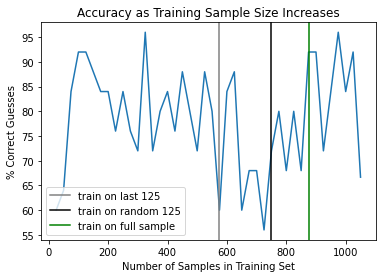

In [185]:
from matplotlib import pyplot as plt
train_size = [k*25 + 25 for k in scores.keys()]
accuracy = [v*100 for v in scores.values()]
plt.plot(train_size, accuracy)
plt.title('Accuracy as Training Sample Size Increases')
plt.xlabel('Number of Samples in Training Set')
plt.ylabel('% Correct Guesses')
plt.axvline(575, label='train on last 125', color='grey')
plt.axvline(750, label='train on random 125', color='black')
plt.axvline(875, label='train on full sample', color='green')
plt.legend()
plt.show()

In [ ]:
import statistics
statistics.mean(scores.values())

### If these figures are to be believed, the tool is capable of automating nearly 80% of the work I was doing with my spreadsheet. In other words, python has made me *5 times more effective* at managing my personal finances.